In [2]:
pip install ta


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=be0d89acfc9f532cc620e3b08027014d1f7b1d99a678f08ddc784f7f10cb3b23
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


<ipython-input-3-4c0d6d09521a>:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


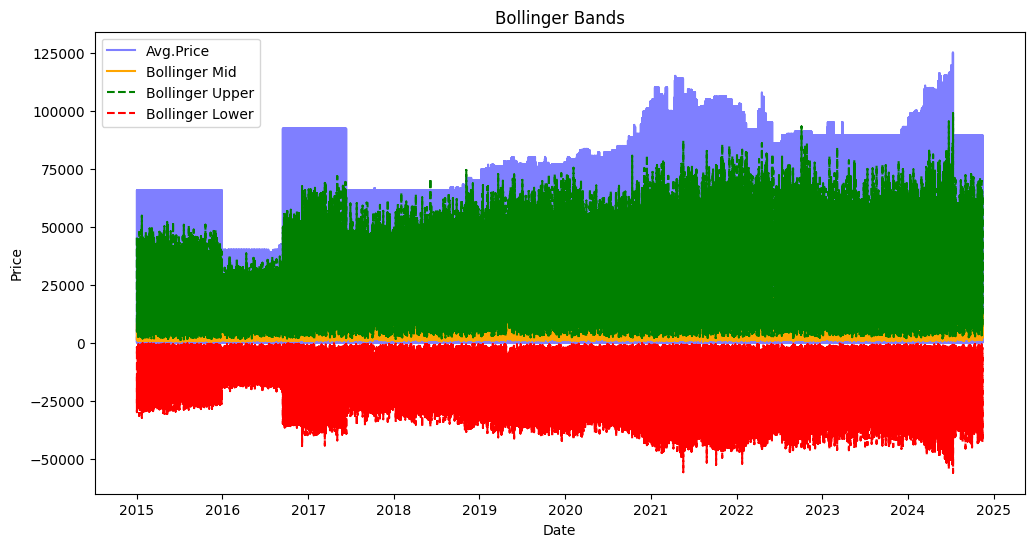

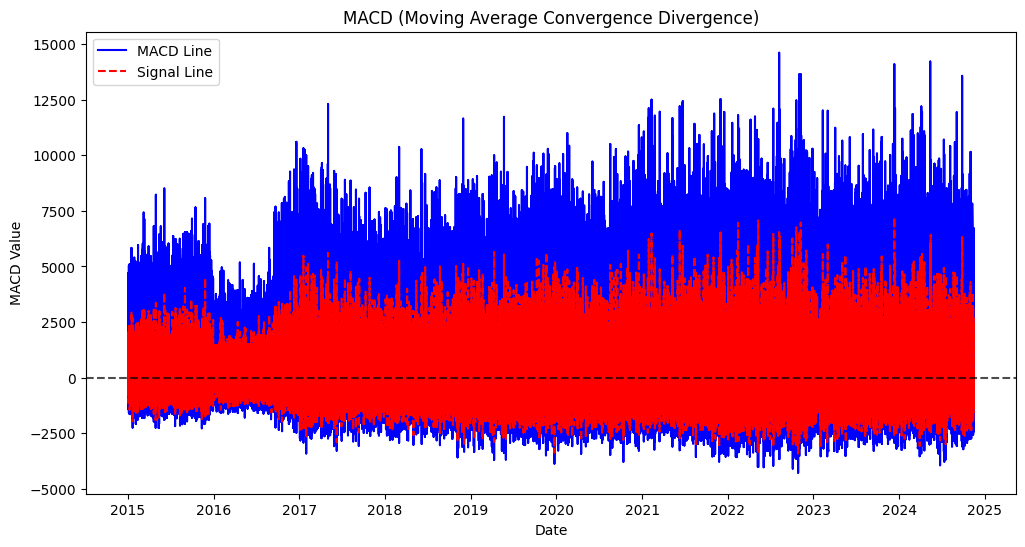

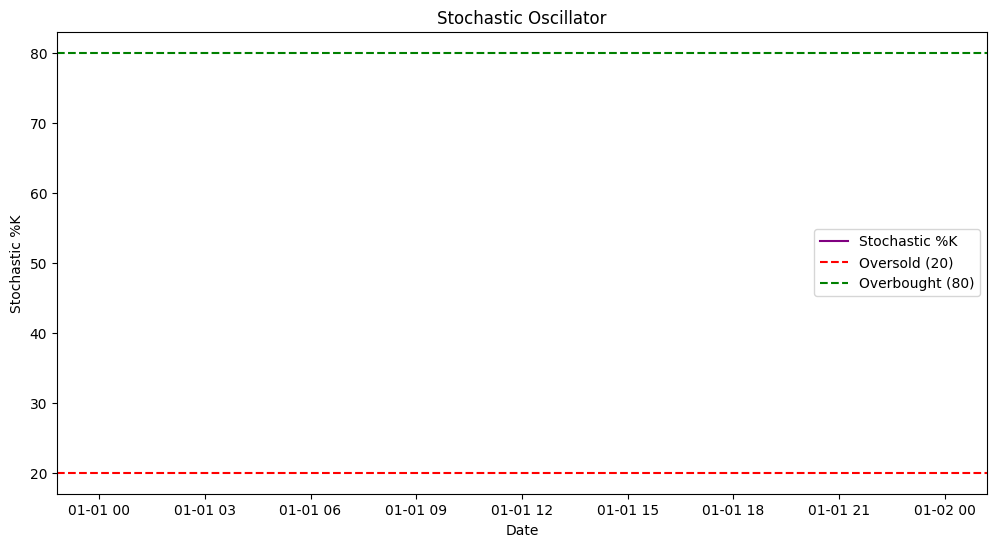

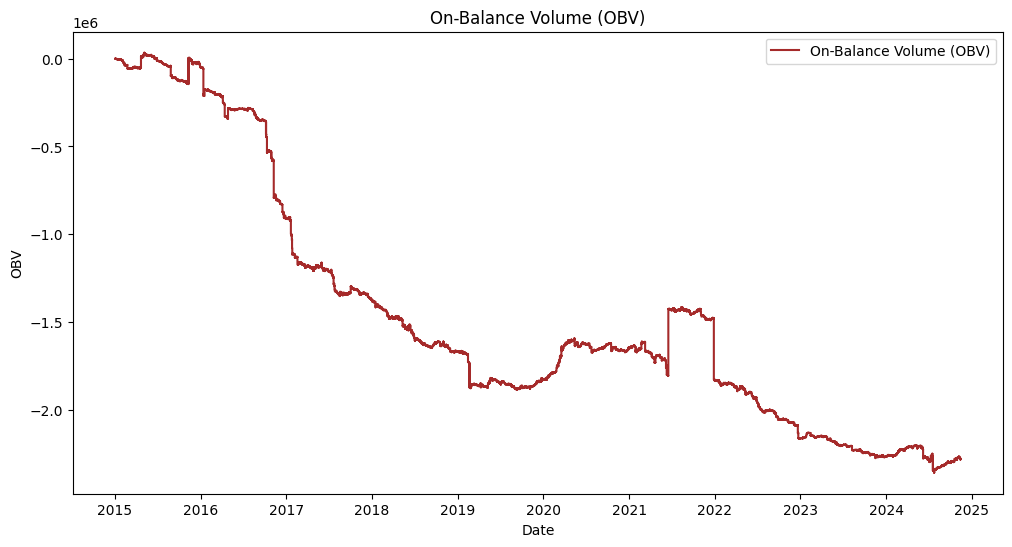

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = 'issuer_data.csv'
data = pd.read_csv(file_path)

# Data Cleaning
# Convert numeric columns to appropriate formats, removing commas where necessary
numeric_columns = ['Last trade price', 'Max', 'Min', 'Avg.Price', 'Volume',
                   'Turnover in BEST in denars', 'Total turnover in denars']

for col in numeric_columns:
    data[col] = data[col].str.replace(',', '').astype(float, errors='ignore')

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y', errors='coerce')

# Drop rows where 'Avg.Price' or 'Date' is missing since they are critical for analysis
data = data.dropna(subset=['Avg.Price', 'Date']).sort_values('Date').reset_index(drop=True)

# Technical Indicators

# Bollinger Bands
def calculate_bollinger_bands(prices, window=20, num_std_dev=2):
    sma = prices.rolling(window=window).mean()
    std_dev = prices.rolling(window=window).std()
    upper_band = sma + (std_dev * num_std_dev)
    lower_band = sma - (std_dev * num_std_dev)
    return sma, upper_band, lower_band

data['BB_Mid'], data['BB_Upper'], data['BB_Lower'] = calculate_bollinger_bands(data['Avg.Price'])

# MACD (Moving Average Convergence Divergence)
def calculate_macd(prices, short_window=12, long_window=26, signal_window=9):
    ema_short = prices.ewm(span=short_window, adjust=False).mean()
    ema_long = prices.ewm(span=long_window, adjust=False).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    return macd_line, signal_line

data['MACD_Line'], data['Signal_Line'] = calculate_macd(data['Avg.Price'])

# Stochastic Oscillator
def calculate_stochastic(prices, low, high, window=14):
    lowest_low = low.rolling(window=window).min()
    highest_high = high.rolling(window=window).max()
    k_percent = 100 * (prices - lowest_low) / (highest_high - lowest_low)
    return k_percent

data['Stochastic_%K'] = calculate_stochastic(data['Avg.Price'], data['Min'], data['Max'])

# On-Balance Volume (OBV)
def calculate_obv(prices, volume):
    obv = [0]
    for i in range(1, len(prices)):
        if prices[i] > prices[i - 1]:
            obv.append(obv[-1] + volume[i])
        elif prices[i] < prices[i - 1]:
            obv.append(obv[-1] - volume[i])
        else:
            obv.append(obv[-1])
    return pd.Series(obv, index=prices.index)

data['OBV'] = calculate_obv(data['Avg.Price'], data['Volume'])

# Visualizations

# Bollinger Bands
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Avg.Price'], label='Avg.Price', color='blue', alpha=0.5)
plt.plot(data['Date'], data['BB_Mid'], label='Bollinger Mid', color='orange')
plt.plot(data['Date'], data['BB_Upper'], label='Bollinger Upper', color='green', linestyle='--')
plt.plot(data['Date'], data['BB_Lower'], label='Bollinger Lower', color='red', linestyle='--')
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# MACD
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['MACD_Line'], label='MACD Line', color='blue')
plt.plot(data['Date'], data['Signal_Line'], label='Signal Line', color='red', linestyle='--')
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.title('MACD (Moving Average Convergence Divergence)')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.show()

# Stochastic Oscillator
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Stochastic_%K'], label='Stochastic %K', color='purple')
plt.axhline(20, color='red', linestyle='--', label='Oversold (20)')
plt.axhline(80, color='green', linestyle='--', label='Overbought (80)')
plt.title('Stochastic Oscillator')
plt.xlabel('Date')
plt.ylabel('Stochastic %K')
plt.legend()
plt.show()

# On-Balance Volume
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['OBV'], label='On-Balance Volume (OBV)', color='brown')
plt.title('On-Balance Volume (OBV)')
plt.xlabel('Date')
plt.ylabel('OBV')
plt.legend()
plt.show()
